In [104]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

### labels

In [140]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('../data_processed/meta_data.csv')
print(y.shape)
# y = y[['Time_BiosetID', 'Host Age Category']]
y.head(1)


(74, 24)


,Unnamed: 0,Time_BiosetID,Day Post-Infection,Species,"GEO ID, link",Study name,Bioset name,Test Samples,Control Samples,Feature Size,...,Viral Dose (PFUs),Viral Severity,"Sample Source (strain, cell)",Host Mouse Strain,Sex,Host Age Category,Host Age Cat,Host Age,Technology,Lab
0,1,0.5_867451,0.5,Mus musculus,GSE36969,Lungs from aged and young mice infected with m...,Lungs from 1yr old (aged) mice - 12hr post SAR...,3,3,627,...,10000,NaN,Lung,BALB/c,female,aged,3-aged (52 weeks old),1yr,Agilent-014868 Whole Mouse Genome Microarray 4...,Michael Katze - University of Washington


#### merge adult and aged group

In [14]:
y['Host Age Category'].value_counts()

adult    37
young    28
aged      9
Name: Host Age Category, dtype: int64

In [18]:
y.loc[y['Host Age Category'] == 'aged', 'Host Age Category'] = 'adult'
y['Host Age Category'].value_counts()

adult    46
young    28
Name: Host Age Category, dtype: int64

In [19]:
y = y.replace({'young':0,'adult':1})
labels = ['young', 'adult'] # for plotting convenience later on

In [29]:
df_x = pd.read_csv('../data_processed/plot_dat.csv', index_col=0).T
print(df_x.shape)
df_x.head(1)

(74, 10564)


,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
0.5_867451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-61.05975,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df_x.index.to_list() == y['Time_BiosetID'].to_list()

True

#### split

In [86]:
# split train and testing
from sklearn.model_selection import train_test_split

# y_ = y.pop('Host Age Category')
X = df_x

X_train, X_test, y_train, y_test = train_test_split(X.index,
                                                    y_,
                                                    test_size=0.2,
                                                    random_state=44,
                                                    stratify=y_)
# X.loc[X_train]  # return dataframe train

In [87]:
print(y_test.value_counts())
y_train.value_counts()

1    9
0    6
Name: Host Age Category, dtype: int64


1    37
0    22
Name: Host Age Category, dtype: int64

In [88]:
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [89]:
X_train = X.loc[X_train]
print(X_train.shape)
X_train.head(1)

(59, 10564)


,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
4_494041,41.86237,0.0,0.0,-21.212507,0.0,18.08325,0.0,0.0,0.0,-38.60139,...,0.0,0.0,0.0,0.0,32.78409,0.0,0.0,0.0,-10.646135,-15.45887


In [90]:
X_test = X[~X.index.isin(X_train.index)]
print(X_test.shape)
X_test.head(1)

(15, 10564)


,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
0.5_867478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_train= X_train.reset_index(drop=True)
X_train.head(1)

,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
0,41.86237,0.0,0.0,-21.212507,0.0,18.08325,0.0,0.0,0.0,-38.60139,...,0.0,0.0,0.0,0.0,32.78409,0.0,0.0,0.0,-10.646135,-15.45887


In [92]:
X_test= X_test.reset_index(drop=True)
X_test.head(1)

,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
X_train.describe()

,March1,43891,43892,March2,March3,March5,March6,44075,Sept2,Sept3,...,Zswim5,Zswim6,Zswim8,Zufsp,Zwilch,Zwint,Zxda,Zxdc,Zyg11b,Zzz3
count,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,11.293577,-5.676667,0.0,-4.138761,3.666019,22.006571,-0.214556,6.416476,-1.853354,-23.933165,...,-8.861452,-0.780815,-0.910696,22.717001,17.831353,5.092241,-1.676427,-5.025238,-3.339970,-14.042053
std,19.543075,14.088811,0.0,9.416688,9.745559,24.214287,6.726063,17.137127,7.841150,29.104344,...,16.707150,6.183800,6.995192,30.027468,32.843332,11.242581,4.456388,10.039432,7.907173,14.131549
min,-56.472930,-57.641540,0.0,-34.712098,-43.717376,0.000000,-16.572974,0.000000,-50.703250,-91.687600,...,-85.907700,-33.738875,-53.731090,0.000000,-77.828280,0.000000,-19.896300,-38.876920,-35.756683,-45.411200
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-45.174985,...,-17.829775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.010555,0.000000,-25.167310
50%,0.000000,0.000000,0.0,0.000000,0.000000,15.277910,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.458870
75%,28.844930,0.000000,0.0,0.000000,10.550148,40.742820,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,49.947105,54.073405,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.399430,0.000000,0.0,18.366350,25.225516,70.918970,19.622464,71.686640,0.000000,0.000000,...,0.000000,13.462429,0.000000,82.910490,73.682190,52.041590,0.000000,18.602300,0.000000,0.000000


### PCA 

25 features explain around 90% of the variance. From 7129 features to 25, not too bad.


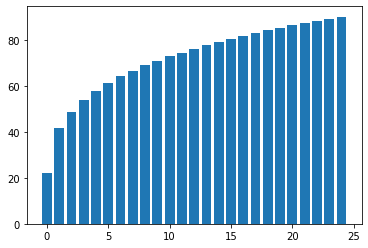

In [95]:
pca = PCA()
pca.fit_transform(X_train)
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, ", not too bad.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [153]:
fig = px.scatter_3d(
    X_train_reduced_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Day Post-Infection',
    size_max=8,
)
fig.show()

In [155]:
import plotly.express as px
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

X_train_reduced_df = pd.DataFrame(X_train_reduced,
                                  columns=['PC1', 'PC2', 'PC3'])
X_train_reduced_df=X_train_reduced_df.join(y.reset_index())
fig = px.scatter_3d(
    X_train_reduced_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Host Age Category',
    size_max=8,
)
fig.show()

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

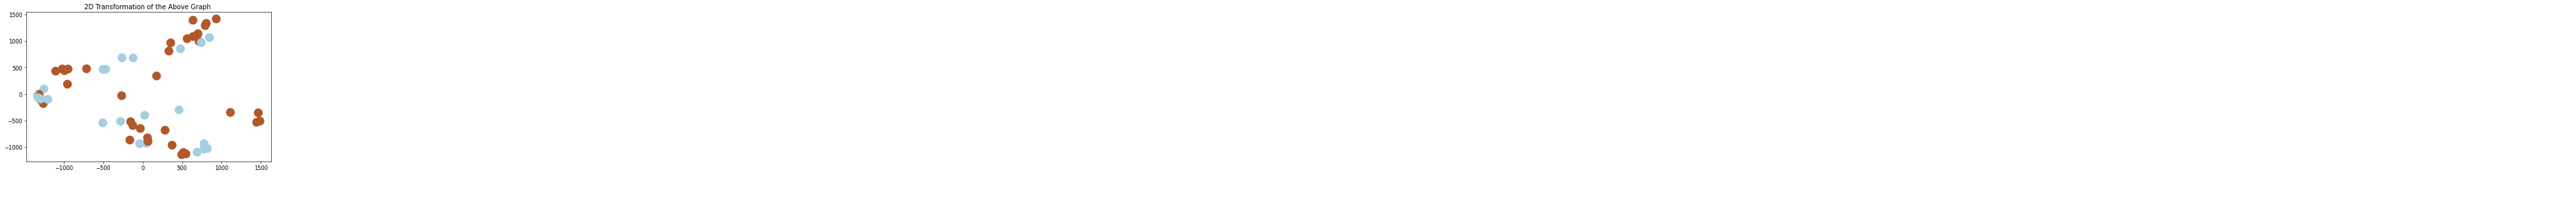

In [121]:
# fig = plt.figure(1, figsize=(10*2, 6*2))
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 60
plt.scatter(X_train_reduced[:, 0],
            X_train_reduced[:, 1],
            c=y_train,
            cmap=plt.cm.Paired,
            linewidths=10)
plt.annotate('Note the Brown Cluster', xy=(30000, -2000))
plt.title("2D Transformation of the Above Graph ")

### Regression Models

#### baseline

In [93]:
print(
    "Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ",
    round(1 - np.mean(y_test), 3),
    ".",
    sep='')

Simply predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of 0.4.


#### Logistic Regression


Best Parameters:
 {'C': 0.01, 'penalty': 'l2'}
Logistic Regression accuracy: 0.533


[Text(0, 0.5, 'young'), Text(0, 1.5, 'adult')]

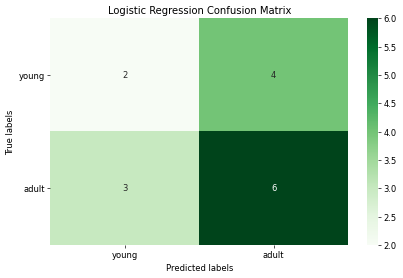

In [122]:
log_grid = {'C': [1e-03, 1e-2, 1e-1, 5e-1, 1, 10], 'penalty': ['l1', 'l2']}

log_estimator = LogisticRegression(solver='liblinear')

log_model = GridSearchCV(estimator=log_estimator,
                         param_grid=log_grid,
                         cv=3,
                         scoring='accuracy')

log_model.fit(X_train, y_train)

print("Best Parameters:\n", log_model.best_params_)

# Select best log model
best_log = log_model.best_estimator_

# Make predictions using the optimised parameters
log_pred = best_log.predict(X_test)

print('Logistic Regression accuracy:',
      round(accuracy_score(y_test, log_pred), 3))

cm_log = confusion_matrix(y_test, log_pred)

ax = plt.subplot()
sns.heatmap(cm_log, annot=True, ax=ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Logistic Regression Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

#### Naive bayes 

Naive Bayes accuracy: 0.467


[Text(0, 0.5, 'young'), Text(0, 1.5, 'adult')]

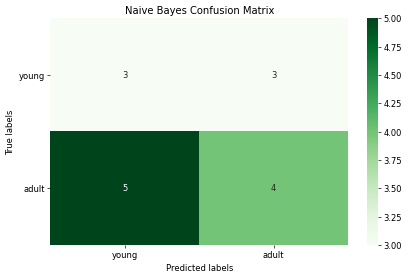

In [126]:
# Create a Gaussian classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print('Naive Bayes accuracy:', round(accuracy_score(y_test, nb_pred), 3))

cm_nb = confusion_matrix(y_test, nb_pred)

ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax=ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Naive Bayes Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

#### K-means

K-means accuracy: 0.467


[Text(0, 0.5, 'young'), Text(0, 1.5, 'adult')]

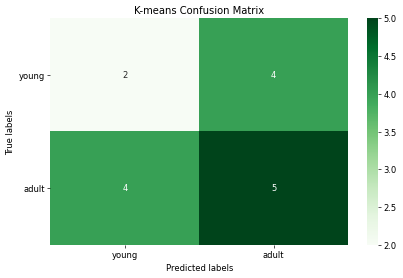

In [125]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
km_pred = kmeans.predict(X_test)

print('K-means accuracy:', round(accuracy_score(y_test, km_pred), 3))

cm_km = confusion_matrix(y_test, km_pred)

ax = plt.subplot()
sns.heatmap(cm_km, annot=True, ax=ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('K-means Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

#### SVM

Best Parameters:
 {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1e-05, 'kernel': 'rbf'}
SVM accuracy: 0.667


[Text(0, 0.5, 'young'), Text(0, 1.5, 'adult')]

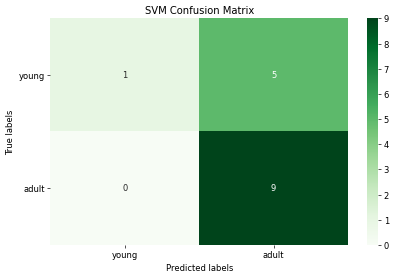

In [127]:
# Parameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10],
    "kernel": ["linear", "rbf", "poly"],
    "decision_function_shape": ["ovo", "ovr"]
}

# Create SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Train the classifier
svm_grid.fit(X_train_pca, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Select best svc
best_svc = svm_grid.best_estimator_

# Make predictions using the optimised parameters
svm_pred = best_svc.predict(X_test_pca)

print('SVM accuracy:', round(accuracy_score(y_test, svm_pred), 3))

cm_svm = confusion_matrix(y_test, svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax=ax, fmt='g', cmap='Greens')

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVM Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)

#### Random Forest

Best Parameters:
 {'bootstrap': True, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.733


[Text(0, 0.5, 'young'), Text(0, 1.5, 'adult')]

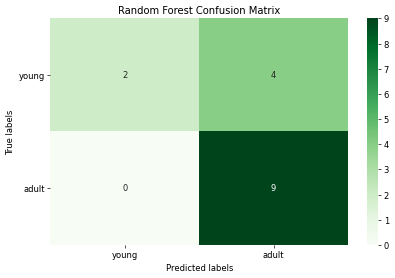

In [128]:
# Hyperparameters search grid
rf_param_grid = {
    'bootstrap': [False, True],
    'n_estimators': [60, 70, 80, 90, 100],
    'max_features': [0.6, 0.65, 0.7, 0.75, 0.8],
    'min_samples_leaf': [8, 10, 12, 14],
    'min_samples_split': [3, 5, 7]
}

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator,
                        param_grid=rf_param_grid,
                        cv=3,
                        scoring='accuracy')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax=ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360)